## Assignment 9: RF & GBDT on Donors choose dataset

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

<p>
Problem Objective - The objective is to predict whether project proposal submitted by a teacher or not, by applying KNN algorithm and deciding the best Feature generation technique for given problem.

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


# 1.1) Reading the data

In [2]:
train_data= pd.read_csv('C:/Users/User/Downloads/train_data.csv', nrows = 50000)
resource_data = pd.read_csv('C:/Users/User/Downloads/resources.csv')


In [3]:
print('Number of data points in the train data', train_data.shape)
print('-'*127)
print('The attributes of the data points in the train data :', train_data.columns.values)
train_data.head(2)

Number of data points in the train data (50000, 17)
-------------------------------------------------------------------------------------------------------------------------------
The attributes of the data points in the train data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [4]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(train_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
train_data['Date'] = pd.to_datetime(train_data['project_submitted_datetime'])
train_data.drop('project_submitted_datetime', axis=1, inplace=True)
train_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
train_data = train_data[cols]

#train_data.head(2)

In [5]:
print("Number of data points in resource data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resource data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

# 1.2) Preprocessing project_subject_categories

In [6]:
pro_sub_catogories = list(train_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
pro_sub_cat_list = []
for i in pro_sub_catogories:
    train = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        train+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        train = train.replace('&','_') # we are replacing the & value into 
    pro_sub_cat_list.append(train.strip())

In [7]:
train_data['clean_categories'] = pro_sub_cat_list
train_data.drop(['project_subject_categories'], axis=1, inplace=True)

In [8]:
from collections import Counter
my_counter = Counter()
for word in train_data['clean_categories'].values:
    my_counter.update(word.split())

In [9]:
pro_sub_cat_dict = dict(my_counter)
sorted_pro_sub_cat_dict = dict(sorted(pro_sub_cat_dict.items(), key=lambda kv: kv[1]))

# 1.3) Preprocessing project_subject_subcategories

In [10]:
pro_sub_subcatogories = list(train_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

pro_sub_subcat_list = []
for i in pro_sub_subcatogories:
    train = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        train +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        train = train.replace('&','_')
    pro_sub_subcat_list.append(train.strip())

In [11]:
train_data['clean_subcategories'] = pro_sub_subcat_list
train_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [12]:
from collections import Counter
my_counter = Counter()
for word in train_data['clean_subcategories'].values:
    my_counter.update(word.split())

In [13]:
pro_sub_subcat_dict = dict(my_counter)
sorted_pro_sub_subcat_dict = dict(sorted(pro_sub_subcat_dict.items(), key=lambda kv: kv[1]))

# 1.4) Text Preprocessing the titles

In [14]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
clean_titles = []

for titles in tqdm(train_data["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    clean_titles.append(title.lower().strip())

100%|██████████████████████████████████| 50000/50000 [00:05<00:00, 9886.72it/s]


In [17]:
train_data["clean_titles"] = clean_titles

In [18]:
train_data.drop(['project_title'], axis=1, inplace=True)

## Number of words in titles

In [19]:
title_word_count = []

In [20]:
for a in train_data["clean_titles"] :
    b = len(a.split())
    title_word_count.append(b)

In [21]:
train_data["title_word_count"] = title_word_count

In [22]:
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state                Date project_grade_category  \
473             GA 2016-04-27 00:53:00          Grades PreK-2   
41558           WA 2016-04-27 01:05:25             Grades 3-5   

                                         project_essay_1  \
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
473                                               2                    1   
41558                                             2                    1   

        clean_categories clean_subcategories  \
473      AppliedLearning    EarlyDevelopment   
41558  Literacy_Language            Literacy   

                             clean_titles  title_word_count  
473    flexible seating flexible learning                 4  
41558   going deep the art inner thinking                 6

# 1.5) Combine 4 project essay

In [23]:
# merge two column text dataframe: 
train_data["essay"] = train_data["project_essay_1"].map(str) + train_data["project_essay_2"].map(str) + \
                        train_data["project_essay_3"].map(str) + train_data["project_essay_4"].map(str)

# 1.6) Text preprocessing the essay

In [24]:
clean_essay = []

for ess in tqdm(train_data["essay"]):
    ess = decontracted(ess)
    ess = ess.replace('\\r', ' ')
    ess = ess.replace('\\"', ' ')
    ess = ess.replace('\\n', ' ')
    ess = re.sub('[^A-Za-z0-9]+', ' ', ess)
    ess = ' '.join(f for f in ess.split() if f not in stopwords)
    clean_essay.append(ess.lower().strip())

100%|███████████████████████████████████| 50000/50000 [01:02<00:00, 797.40it/s]


In [25]:
train_data["clean_essays"] = clean_essay

In [26]:
train_data.drop(['essay'], axis=1, inplace=True)

## Number of words in Essay

In [27]:
essay_word_count = []

In [28]:
for ess in train_data["clean_essays"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [29]:
train_data["essay_word_count"] = essay_word_count

In [30]:
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state                Date project_grade_category  \
473             GA 2016-04-27 00:53:00          Grades PreK-2   
41558           WA 2016-04-27 01:05:25             Grades 3-5   

                                         project_essay_1  \
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
473                                               2                    1   
41558                                             2                    1   

        clean_categories clean_subcategories  \
473      AppliedLearning    EarlyDevelopment   
41558  Literacy_Language            Literacy   

                             clean_titles  title_word_count  \
473    flexible seating flexible learning                 4   
41558   going deep the art inner thinking                 6   

                                            clean_essays  essay_word_count  
473    i recently read article giving students choice...               127  
41558  my students crave challenge eat obstacles brea...               114

# 1.7) Calculate sentiment score in essay

In [31]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [32]:
neg = []
pos = []
neu = []
compound = []

for a in tqdm(train_data["clean_essays"]) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)

100%|████████████████████████████████████| 50000/50000 [11:49<00:00, 70.50it/s]


In [33]:
train_data["pos"] = pos

In [34]:
train_data["neg"] = neg

In [35]:
train_data["neu"] = neu

In [36]:
train_data["compound"] = compound

In [37]:
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state                Date project_grade_category  \
473             GA 2016-04-27 00:53:00          Grades PreK-2   
41558           WA 2016-04-27 01:05:25             Grades 3-5   

                                         project_essay_1  \
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  ...  \
473    We need a classroom rug that we can use as a c...  ...   
41558  With the new common core standards that have b...  ...   

        clean_categories clean_subcategories  \
473      AppliedLearning    EarlyDevelopment   
41558  Literacy_Language            Literacy   

                             clean_titles  title_word_count  \
473    flexible seating flexible learning                 4   
41558   going deep the art inner thinking                 6   

                                            clean_essays essay_word_count  \
473    i recently read article giving students choice...              127   
41558  my students crave challenge eat obstacles brea...              114   

         pos    neg    neu  compound  
473    0.187  0.030  0.783    0.9524  
41558  0.288  0.029  0.683    0.9873  

[2 rows x 24 columns]

In [38]:
train_data.project_grade_category = train_data.project_grade_category.str.replace('\s','_')
train_data['project_grade_category'].value_counts()
train_data.project_grade_category = train_data.project_grade_category.str.replace('-','_')
train_data['project_grade_category'].value_counts()

Grades_PreK_2    20316
Grades_3_5       16968
Grades_6_8        7750
Grades_9_12       4966
Name: project_grade_category, dtype: int64

In [39]:
train_data.teacher_prefix = train_data.teacher_prefix.str.replace('.',' ')
train_data['teacher_prefix'].value_counts()

Mrs        26140
Ms         17936
Mr          4859
Teacher     1061
Dr             2
Name: teacher_prefix, dtype: int64

In [40]:
train_data.teacher_prefix = train_data.teacher_prefix.str.replace('NaN','0')

# 1.8) Train-Test split

In [41]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_data['project_is_approved'],\
                        test_size=0.33, stratify =train_data['project_is_approved'])
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [42]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
#X_cv.drop(['project_is_approved'], axis=1, inplace=True)

# 1.9) Preparing data for model

In [43]:
train_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'clean_titles',
       'title_word_count', 'clean_essays', 'essay_word_count', 'pos', 'neg',
       'neu', 'compound'],
      dtype='object')

# Vectorizing the categorial features

## 1.9.1) One hot encode - Clean categories of project_subject_category

In [44]:
# we use count vectorizer to convert the values into one 

from sklearn.feature_extraction.text import CountVectorizer

vectorizer_proj = CountVectorizer(vocabulary=list(sorted_pro_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_proj.fit(X_train['clean_categories'].values)

categories_one_hot_train = vectorizer_proj.transform(X_train['clean_categories'].values)
categories_one_hot_test = vectorizer_proj.transform(X_test['clean_categories'].values)
#categories_one_hot_cv = vectorizer_proj.transform(X_cv['clean_categories'].values)

print(vectorizer_proj.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",categories_one_hot_test.shape)
#print("Shape of matrix of CV data after one hot encoding ",categories_one_hot_cv.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix of Train data after one hot encoding  (33500, 9)
Shape of matrix of Test data after one hot encoding  (16500, 9)


## 1.9.2) One hot encode - Clean categories of project_sub_subcategories

In [45]:
# we use count vectorizer to convert the values into one 

vectorizer_sub_proj = CountVectorizer(vocabulary=list(sorted_pro_sub_subcat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_proj.fit(X_train['clean_subcategories'].values)

sub_categories_one_hot_train = vectorizer_sub_proj.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer_sub_proj.transform(X_test['clean_subcategories'].values)
#sub_categories_one_hot_cv = vectorizer_sub_proj.transform(X_cv['clean_subcategories'].values)

print(vectorizer_sub_proj.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",sub_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",sub_categories_one_hot_test.shape)
#print("Shape of matrix of Cross Validation data after one hot encoding ",sub_categories_one_hot_cv.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix of Train data after one hot encoding  (33500, 30)
Shape of matrix of Test data after one hot encoding  (16500, 30)


## 1.9.3) One hot encode - School states

In [46]:
my_counter = Counter()
for state in train_data['school_state'].values:
    my_counter.update(state.split())

In [47]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [48]:
## we use count vectorizer to convert the values into one hot encoded features
vectorizer_state = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_state.fit(X_train['school_state'].values)

school_state_categories_one_hot_train = vectorizer_state.transform(X_train['school_state'].values)
school_state_categories_one_hot_test = vectorizer_state.transform(X_test['school_state'].values)
#school_state_categories_one_hot_cv = vectorizer_state.transform(X_cv['school_state'].values)

print(vectorizer_state.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",school_state_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",school_state_categories_one_hot_test.shape)
#print("Shape of matrix of Cross Validation data after one hot encoding ",school_state_categories_one_hot_cv.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'NH', 'SD', 'NE', 'AK', 'DE', 'WV', 'ME', 'NM', 'HI', 'DC', 'KS', 'ID', 'IA', 'AR', 'CO', 'MN', 'OR', 'MS', 'KY', 'NV', 'MD', 'TN', 'CT', 'AL', 'UT', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'MA', 'LA', 'WA', 'MO', 'IN', 'OH', 'PA', 'MI', 'GA', 'SC', 'IL', 'NC', 'FL', 'TX', 'NY', 'CA']
Shape of matrix of Train data after one hot encoding  (33500, 51)
Shape of matrix of Test data after one hot encoding  (16500, 51)


## 1.9.4) One hot encode - Teacher_prefix

In [49]:
my_counter = Counter()
for teacher_prefix in train_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [50]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [51]:
## we use count vectorizer to convert the values into one hot encoded features
## Unlike the previous Categories this category returns a
## ValueError: np.nan is an invalid document, expected byte or unicode string.
## The link below explains h0w to tackle such discrepancies.
## https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document/39308809#39308809
vectorizer_teacher = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_teacher.fit(X_train['teacher_prefix'].values.astype("U"))

teacher_prefix_categories_one_hot_train = vectorizer_teacher.transform(X_train['teacher_prefix'].values.astype("U"))
teacher_prefix_categories_one_hot_test = vectorizer_teacher.transform(X_test['teacher_prefix'].values.astype("U"))
#teacher_prefix_categories_one_hot_cv = vectorizer_teacher.transform(X_cv['teacher_prefix'].values.astype("U"))

print(vectorizer_teacher.get_feature_names())

print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_test.shape)
#print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_cv.shape)

['nan', 'Dr', 'Teacher', 'Mr', 'Ms', 'Mrs']
Shape of matrix after one hot encoding  (33500, 6)
Shape of matrix after one hot encoding  (16500, 6)


## 1.9.5) One hot encode - project_grade_category

In [52]:
my_counter = Counter()
for project_grade in train_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [53]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [54]:
## we use count vectorizer to convert the values into one hot encoded features
vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(X_train['project_grade_category'].values)

project_grade_categories_one_hot_train = vectorizer_grade.transform(X_train['project_grade_category'].values)
project_grade_categories_one_hot_test = vectorizer_grade.transform(X_test['project_grade_category'].values)
#project_grade_categories_one_hot_cv = vectorizer_grade.transform(X_cv['project_grade_category'].values)

print(vectorizer_grade.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",project_grade_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",project_grade_categories_one_hot_test.shape)
#print("Shape of matrix of Cross Validation data after one hot encoding ",project_grade_categories_one_hot_cv.shape)

['Grades_9_12', 'Grades_6_8', 'Grades_3_5', 'Grades_PreK_2']
Shape of matrix of Train data after one hot encoding  (33500, 4)
Shape of matrix of Test data after one hot encoding  (16500, 4)


# Vectorizing the text data

## I) Bag of words - with min_df=10

### Bag of words - Train Data - Essays

In [55]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).

vectorizer_bow_essay = CountVectorizer(min_df=10)
vectorizer_bow_essay.fit(X_train["clean_essays"])
text_bow_train = vectorizer_bow_essay.transform(X_train["clean_essays"])
print("Shape of matrix after one hot encoding ",text_bow_train.shape)

Shape of matrix after one hot encoding  (33500, 10436)


### Bag of words - Test Data - Essays

In [56]:
text_bow_test = vectorizer_bow_essay.transform(X_test["clean_essays"])
print("Shape of matrix after one hot encoding ",text_bow_test.shape)

Shape of matrix after one hot encoding  (16500, 10436)


### Bag of words - CV Data - Essays

In [57]:
#text_bow_cv = vectorizer_bow_essay.transform(X_cv["clean_essays"])
#print("Shape of matrix after one hot encoding ",text_bow_cv.shape)

### Bag of words - Train Data - Title

In [58]:
vectorizer_bow_title = CountVectorizer(min_df=10)

vectorizer_bow_title.fit(X_train["clean_titles"])

title_bow_train = vectorizer_bow_title.transform(X_train["clean_titles"])
print("Shape of matrix after one hot encoding ",title_bow_train.shape)

Shape of matrix after one hot encoding  (33500, 1630)


### Bag of words - Test Data - Title

In [59]:
title_bow_test = vectorizer_bow_title.transform(X_test["clean_titles"])
print("Shape of matrix after one hot encoding ",title_bow_test.shape)

Shape of matrix after one hot encoding  (16500, 1630)


### Bag of words - CV Data - Title

In [60]:
#title_bow_cv = vectorizer_bow_title.transform(X_cv["clean_titles"])
#print("Shape of matrix after one hot encoding ",title_bow_cv.shape)

## II) TFIDF vectorizer with min_df=10

### TFIDF - Train Data - Essays

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
vectorizer_tfidf_essay.fit(X_train["clean_essays"])

text_tfidf_train = vectorizer_tfidf_essay.transform(X_train["clean_essays"])
print("Shape of matrix after one hot encoding ",text_tfidf_train.shape)

Shape of matrix after one hot encoding  (33500, 10436)


### TFIDF - Test Data - Essays

In [62]:
text_tfidf_test = vectorizer_tfidf_essay.transform(X_test["clean_essays"])
print("Shape of matrix after one hot encoding ",text_tfidf_test.shape)

Shape of matrix after one hot encoding  (16500, 10436)


### TFIDF - Train Data - Titles

In [63]:
vectorizer_tfidf_titles = TfidfVectorizer(min_df=10)

vectorizer_tfidf_titles.fit(X_train["clean_titles"])
title_tfidf_train = vectorizer_tfidf_titles.transform(X_train["clean_titles"])
print("Shape of matrix after one hot encoding ",title_tfidf_train.shape)

Shape of matrix after one hot encoding  (33500, 1630)


### TFIDF - Test Data - Titles

In [64]:
title_tfidf_test = vectorizer_tfidf_titles.transform(X_test["clean_titles"])
print("Shape of matrix after one hot encoding ",title_tfidf_test.shape)

Shape of matrix after one hot encoding  (16500, 1630)


## III) Using pretrained model - Avg W2V

In [65]:
with open ('glove_vectors', "rb") as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

### Train - Essays

In [66]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_train = []; 

for sentence in tqdm(X_train["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████| 33500/33500 [00:22<00:00, 1458.02it/s]


33500
300


### Test - Essays

In [67]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_test = []; 

for sentence in tqdm(X_test["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████| 16500/16500 [00:08<00:00, 1905.86it/s]


16500
300


### Train - Titles


In [68]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["clean_titles"]): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_train.append(vector)

print(len(avg_w2v_vectors_titles_train))
print(len(avg_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████| 33500/33500 [00:01<00:00, 18641.12it/s]


33500
300


### Test - Titles

In [69]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["clean_titles"]): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_test.append(vector)

print(len(avg_w2v_vectors_titles_test))
print(len(avg_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████| 16500/16500 [00:01<00:00, 13523.82it/s]


16500
300


## IV) Using pretrained model - TFIDF weighted W2V

### Train - Essays

In [70]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["clean_essays"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [71]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████| 33500/33500 [02:30<00:00, 222.23it/s]


33500
300


### Test - Essays

In [72]:
# compute average word2vec for each review.

tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████| 16500/16500 [01:10<00:00, 233.02it/s]


16500
300


### Train - Titles

In [73]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["clean_titles"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [74]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_train = []; 

for sentence in tqdm(X_train["clean_titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_train.append(vector)

print(len(tfidf_w2v_vectors_titles_train))
print(len(tfidf_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████| 33500/33500 [00:01<00:00, 17761.44it/s]


33500
300


### Test - Titles

In [75]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_test = []; 

for sentence in tqdm(X_test["clean_titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_test.append(vector)

print(len(tfidf_w2v_vectors_titles_test))
print(len(tfidf_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████| 16500/16500 [00:00<00:00, 17440.87it/s]


16500
300


# 1.8) Vectorizing numerical features 

In [76]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [77]:
# join two dataframes in python: 
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')
#X_cv = pd.merge(X_cv, price_data, on='id', how='left')

### 1) Price

In [78]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

price_train = normalizer.transform(X_train['price'].values.reshape(-1,1))
#price_cv = normalizer.transform(X_cv['price'].values.reshape(-1,1))
price_test = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
#print(price_cv.shape, y_cv.shape)
print(price_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 2) Quantity

In [79]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
#quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape)
#print(quantity_cv.shape, y_cv.shape)
print(quantity_test.shape, y_test.shape)
print("="*100)


After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 3) Project proposal previously by Teacher

In [80]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#prev_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape, y_train.shape)
#print(prev_projects_cv.shape, y_cv.shape)
print(prev_projects_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 4) Number of word in title

In [81]:
normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(-1,1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(-1,1))
#title_word_count_cv = normalizer.transform(X_cv['title_word_count'].values.reshape(-1,1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(title_word_count_train.shape, y_train.shape)
#print(title_word_count_cv.shape, y_cv.shape)
print(title_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 5) Number of word in essay

In [82]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(-1,1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(-1,1))
#essay_word_count_cv = normalizer.transform(X_cv['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(essay_word_count_train.shape, y_train.shape)
#print(essay_word_count_cv.shape, y_cv.shape)
print(essay_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 6) Essay sentiment - pos

In [83]:
normalizer = Normalizer()

normalizer.fit(X_train['pos'].values.reshape(-1,1))

essay_sent_pos_train = normalizer.transform(X_train['pos'].values.reshape(-1,1))
#essay_sent_pos_cv = normalizer.transform(X_cv['pos'].values.reshape(-1,1))
essay_sent_pos_test = normalizer.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_pos_train.shape, y_train.shape)
#print(essay_sent_pos_cv.shape, y_cv.shape)
print(essay_sent_pos_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 7) Essay sentiment - neg

In [84]:
normalizer = Normalizer()

normalizer.fit(X_train['neg'].values.reshape(-1,1))

essay_sent_neg_train = normalizer.transform(X_train['neg'].values.reshape(-1,1))
#essay_sent_neg_cv = normalizer.transform(X_cv['neg'].values.reshape(-1,1))
essay_sent_neg_test = normalizer.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_neg_train.shape, y_train.shape)
#print(essay_sent_neg_cv.shape, y_cv.shape)
print(essay_sent_neg_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 8) Essay sentiment - neu

In [85]:
normalizer = Normalizer()

normalizer.fit(X_train['neu'].values.reshape(-1,1))

essay_sent_neu_train = normalizer.transform(X_train['neu'].values.reshape(-1,1))
#essay_sent_neu_cv = normalizer.transform(X_cv['neu'].values.reshape(-1,1))
essay_sent_neu_test = normalizer.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_neu_train.shape, y_train.shape)
#print(essay_sent_neu_cv.shape, y_cv.shape)
print(essay_sent_neu_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 9) Essay sentiment - compound

In [86]:
normalizer = Normalizer()

normalizer.fit(X_train['compound'].values.reshape(-1,1))

essay_sent_compound_train = normalizer.transform(X_train['compound'].values.reshape(-1,1))
#essay_sent_compound_cv = normalizer.transform(X_cv['compound'].values.reshape(-1,1))
essay_sent_compound_test = normalizer.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_compound_train.shape, y_train.shape)
#print(essay_sent_compound_cv.shape, y_cv.shape)
print(essay_sent_compound_test.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


## Feature Aggregation:


In [87]:
#https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb

#Feature aggregation
f1=vectorizer_proj.get_feature_names()
f2=vectorizer_sub_proj.get_feature_names()
f3=vectorizer_state.get_feature_names()
f4=vectorizer_teacher.get_feature_names()
f5=vectorizer_grade.get_feature_names()
fb=vectorizer_bow_essay.get_feature_names()
ft=vectorizer_bow_title.get_feature_names()
fb1=vectorizer_tfidf_essay.get_feature_names()
ft1=vectorizer_tfidf_titles.get_feature_names()

feature_agg_bow = f1 + f2 + f3 + f4 + f5 + fb + ft
feature_agg_tfidf = f1 + f2 + f3 + f4 + f5 + fb1 + ft1

# p is price, q is quantity, t is teacher previous year projects
feature_agg_bow.append('price')
feature_agg_tfidf.append('price')
feature_agg_bow.append('quantity')
feature_agg_tfidf.append('quantity')
feature_agg_bow.append('teacher_previous_projects')
feature_agg_tfidf.append('teacher_previous_projects')



In [88]:
bow_features_names = []

## Obtain Feature names for Project titles

for a in vectorizer_proj.get_feature_names() :
    bow_features_names.append(a)
    
    
## Obtain Feature names for Project Sub-titles
for a in vectorizer_sub_proj.get_feature_names() :
    bow_features_names.append(a)
    
## Obtain Feature names for states 
for a in vectorizer_state.get_feature_names() :
    bow_features_names.append(a)
    
## Obtain Feature names for Project Grade Category
for a in vectorizer_grade.get_feature_names() :
    bow_features_names.append(a)
    
## Obtain Feature names for Teacher Title
for a in vectorizer_teacher.get_feature_names() :
    bow_features_names.append(a)
    
bow_features_names.append("price")
bow_features_names.append("quantity")
bow_features_names.append("prev_proposed_projects")
bow_features_names.append("title_word_count")
bow_features_names.append("essay_word_count")
bow_features_names.append("pos")
bow_features_names.append("neg")
bow_features_names.append("neu")
bow_features_names.append("compound")
for a in vectorizer_bow_title.get_feature_names() :
    bow_features_names.append(a)
for a in vectorizer_bow_essay.get_feature_names() :
    bow_features_names.append(a)
len(bow_features_names)


12175

In [89]:
tfidf_features_names = []

## Obtain Feature names for Project titles

for a in vectorizer_proj.get_feature_names() :
    tfidf_features_names.append(a)

## Obtain Feature names for Project Sub-titles
for a in vectorizer_sub_proj.get_feature_names() :
    tfidf_features_names.append(a)
    
## Obtain Feature names for states 
for a in vectorizer_state.get_feature_names() :
    tfidf_features_names.append(a)
    
## Obtain Feature names for Project Grade Category
for a in vectorizer_grade.get_feature_names() :
    tfidf_features_names.append(a)
    
## Obtain Feature names for Teacher Title
for a in vectorizer_teacher.get_feature_names() :
    tfidf_features_names.append(a)
    
tfidf_features_names.append("price")
tfidf_features_names.append("price")
tfidf_features_names.append("prev_proposed_projects")
tfidf_features_names.append("title_word_count")
tfidf_features_names.append("essay_word_count")
tfidf_features_names.append("pos")
tfidf_features_names.append("neg")
tfidf_features_names.append("neu")
tfidf_features_names.append("compound")

for a in vectorizer_tfidf_titles.get_feature_names() :
    tfidf_features_names.append(a)
for a in vectorizer_tfidf_essay.get_feature_names() :
    tfidf_features_names.append(a)
len(tfidf_features_names)


12175

## Assignment 9: RF & GBDT on Donors choose dataset

In [91]:
#### Response Coding: Example

In [92]:
<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

SyntaxError: invalid syntax (<ipython-input-92-c13ca6593fe0>, line 1)

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

## Set 1: Categorical, Numerical features + Project_title(BOW) + Preprocessed_essay (BOW  with min_df=10)


In [93]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr1 = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, title_bow_train, text_bow_train)).tocsr()
X_te1 = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, title_bow_test, text_bow_test)).tocsr()
#X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, title_bow_cv, text_bow_cv)).tocsr()


print("Final Data matrix")
print(X_tr1.shape, y_train.shape)
#print(X_cv.shape, y_cv.shape)
print(X_te1.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 12175) (33500,)
(16500, 12175) (16500,)


In [94]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier()


parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'n_estimators': [5, 10, 50, 100, 250]}

clf1 = GridSearchCV(rfc1, parameters, cv=3, scoring='roc_auc')
se1 = clf1.fit(X_tr1, y_train)

KeyboardInterrupt: 

In [ ]:
import seaborn as sns; sns.set()


max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]


fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

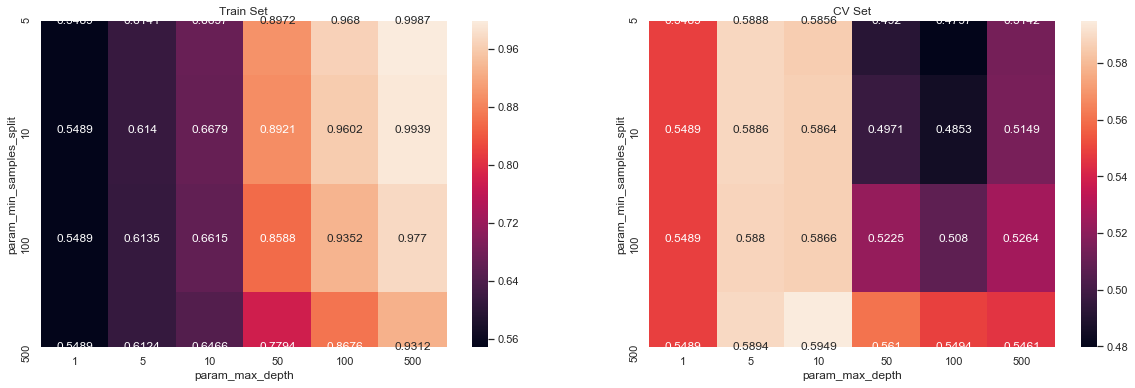

In [188]:
##https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()


## Best Estimator and Best tune parameters


In [189]:
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
print(clf1.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf1.score(X_tr1,y_train))
print(clf1.score(X_te1,y_test))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.6577012452197715
0.6074177656560029


In [190]:
# Best tune parameters
best_tune_parameters=[{'max_depth':[10], 'min_samples_split':[500] } ]

clf1.get_params().keys()


dict_keys(['cv', 'error_score', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__presort', 'estimator__random_state', 'estimator__splitter', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

## ROC Curve:


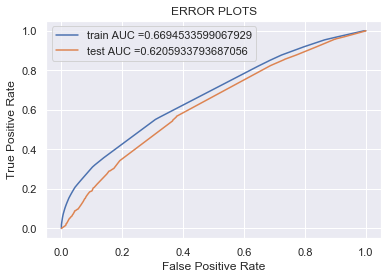

In [191]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function



clf1= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
classifier_bow=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)

clf1.fit(X_tr1, y_train)

# for visulation

classifier_bow.fit(X_tr1, y_train)

y_train_pred1 = clf1.predict_proba(X_tr1) [:,1]
y_test_pred1 = clf1.predict_proba(X_te1) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

plt.show()




## Confusion Matrix:


In [192]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions


## Train

In [193]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)))



Train confusion matrix
the maximum value of tpr*(1-fpr) 0.14 for threshold 0.45
[[ 3492  1676]
 [12352 15980]]


the maximum value of tpr*(1-fpr) 0.14 for threshold 0.45


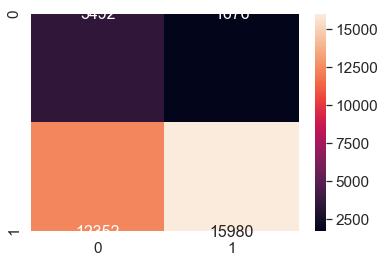

In [194]:
conf_matr_df_train_1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_1, annot=True,annot_kws={"size": 16}, fmt='g')

## test

In [195]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.17 for threshold 0.45
[[1583  963]
 [6040 7914]]


the maximum value of tpr*(1-fpr) 0.17 for threshold 0.45


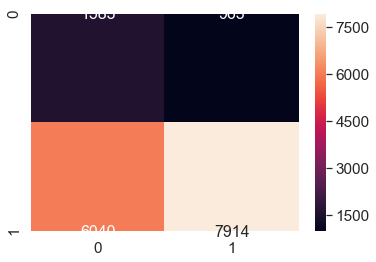

In [196]:
conf_matr_df_test_1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)), range(2),range(2))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_1, annot=True,annot_kws={"size": 16}, fmt='g')


## Visualizing Decision Tree:


In [197]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\User\Desktop\graphviz'


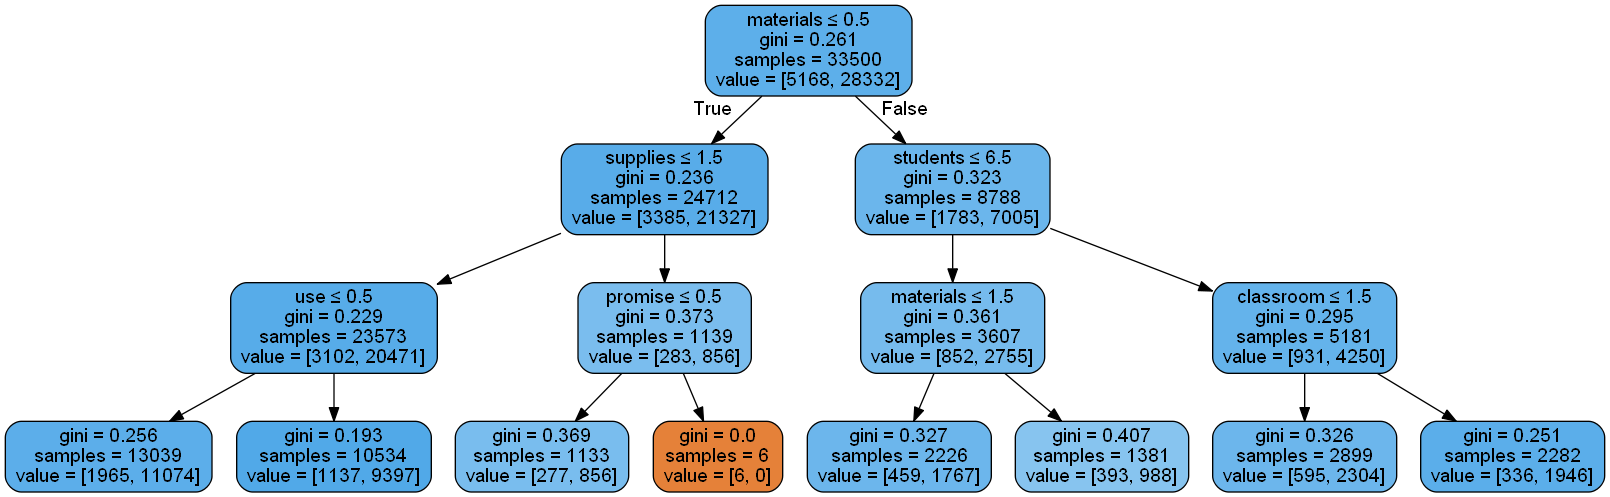

In [198]:
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=3)
clf1 = dtree.fit(X_tr1, y_train)

dot_data = StringIO()

#dt_feat_names = list(X_test.columns)
#dt_target_names = [str(s) for s in [0,1]]
export_graphviz(clf1, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=bow_features_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


## False Positive words from BOW encoded Essays

In [199]:
bow_test = text_bow_test.todense()
bow_test.shape

(16500, 10446)

In [200]:
vectorizer_bow_essay = CountVectorizer(min_df=10)

a = vectorizer_bow_essay.fit(X_train["clean_essays"])

bow_features = a.get_feature_names()
len(bow_features)



10446

In [201]:
y_test_conaverted = list(y_test[::])

false_positives_index_p = []
fp_count = 0

for i in tqdm(range(len(y_test_pred1))):
    if y_test_conaverted[i] == 0 and y_test_pred1[i] <= 0.839:
        false_positives_index_p.append(i)
        fp_count = fp_count + 1 
    else :
        continue

100%|████████████████████████████████| 16500/16500 [00:00<00:00, 445917.92it/s]


In [202]:
fp_count

2438

In [203]:
false_positives_index_p[0:7]

[5, 12, 19, 37, 49, 51, 62]

In [204]:
df1 = pd.DataFrame(bow_test)
df1_final = df1.iloc[false_positives_index_p,:]

df1_final.shape

df1_final[0].sum()

6

In [205]:
best_indices = []

for j in range(8885):
    
    s = df1_final[j].sum()
    
    if s >= 100 :
        best_indices.append(j)
    else :
        continue

len(best_indices)

470

In [206]:
best_indices[0:10]

[3, 57, 124, 184, 185, 186, 212, 213, 214, 226]

In [207]:
bow_features[0:10]

['00', '000', '10', '100', '1000', '101', '103', '104', '10th', '11']

In [208]:
fp_words = []

for a in best_indices :
    fp_words.append(str(bow_features[a]))

fp_words[0:10]

['100',
 '21st',
 '5th',
 'abilities',
 'ability',
 'able',
 'academic',
 'academically',
 'academics',
 'access']

## Word cloud for false positive words:

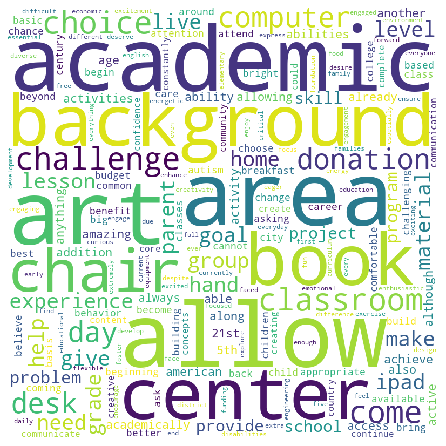

In [209]:
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
from wordcloud import WordCloud, STOPWORDS


#convert list to string and generate
unique_string=(" ").join(fp_words)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords =stopwords,min_font_size=10).generate(unique_string)

plt.figure(figsize=(6,6))

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
plt.close()

## Box - Plot with the price of these False positive data points


In [210]:
len(false_positives_index_p)

2438

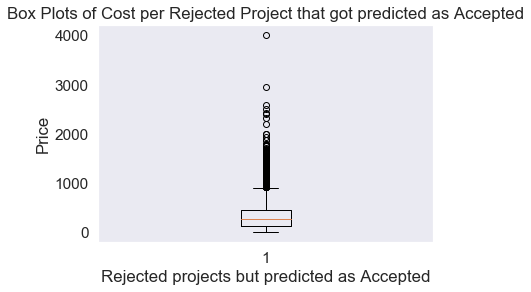

In [211]:
df1 = pd.DataFrame(X_test['price'])
df1_final = df1.iloc[false_positives_index_p,:]

plt.boxplot(df1_final.values)
plt.title('Box Plots of Cost per Rejected Project that got predicted as Accepted')
plt.xlabel('Rejected projects but predicted as Accepted')
plt.ylabel('Price')
plt.grid()
plt.show()

## PDF with the Teacher_number_of_previously_posted_projects of these False Positive data points

In [213]:
df1 = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
df1_final = df1.iloc[false_positives_index_p,:]
df1_final.shape

(2438, 1)

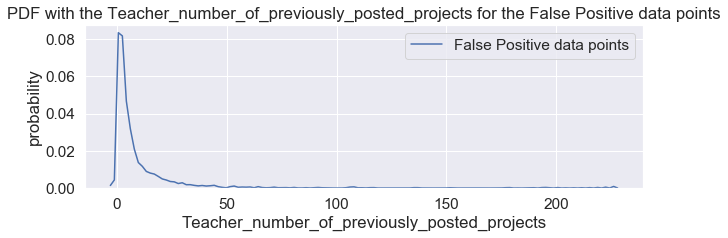

In [214]:
plt.figure(figsize=(10,3))
sns.distplot(df1_final.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.show()

## Set 2 : Categorical, Numerical features + Project_title(TFIDF) + Preprocessed_essay (TFIDF min_df=10)

In [90]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr2 = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, title_tfidf_train, text_tfidf_train)).tocsr()
X_te2 = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, title_tfidf_test, text_tfidf_test)).tocsr()
#X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, title_tfidf_cv, text_tfidf_cv)).tocsr()

print("Final Data matrix")
print(X_tr2.shape, y_train.shape)
#print(X_cv.shape, y_cv.shape)
print(X_te2.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 12182) (33500,)
(16500, 12182) (16500,)


In [91]:
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]}

clf2 = GridSearchCV(dt, parameters, cv= 3, scoring='roc_auc', return_train_score = True,n_jobs = -1)

clf2.fit(X_tr2, y_train)

train_auc= clf2.cv_results_['mean_train_score']
train_auc_std= clf2.cv_results_['std_train_score']
cv_auc = clf2.cv_results_['mean_test_score'] 
cv_auc_std= clf2.cv_results_['std_test_score']

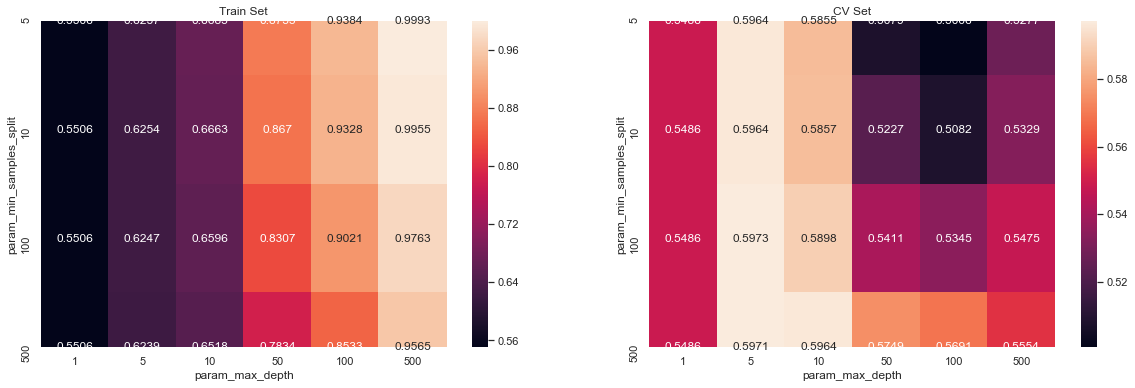

In [217]:
##https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()


## ROC Curve:


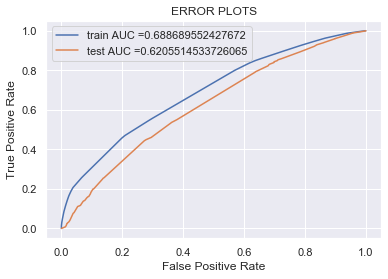

In [219]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function



clf2= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
classifier_bow=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)

clf2.fit(X_tr2, y_train)

# for visulation

classifier_bow.fit(X_tr2, y_train)

y_train_pred1 = clf2.predict_proba(X_tr2) [:,1]
y_test_pred1 = clf2.predict_proba(X_te2) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

plt.show()




## Confusion Matrix:


In [220]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions


In [221]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)))

print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.13 for threshold 0.49
[[ 3624  1544]
 [12555 15777]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.17 for threshold 0.49
[[1626  920]
 [6479 7475]]


the maximum value of tpr*(1-fpr) 0.13 for threshold 0.49


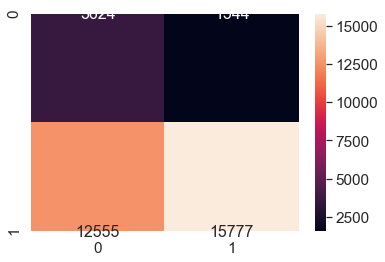

In [222]:
conf_matr_df_train_1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_1, annot=True,annot_kws={"size": 16}, fmt='g')

the maximum value of tpr*(1-fpr) 0.17 for threshold 0.49


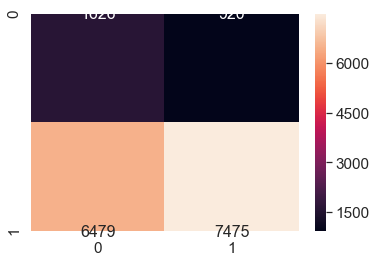

In [223]:
conf_matr_df_test_1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)), range(2),range(2))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_1, annot=True,annot_kws={"size": 16}, fmt='g')


## Visualizing Decision Tree:


In [224]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\User\Desktop\graphviz'


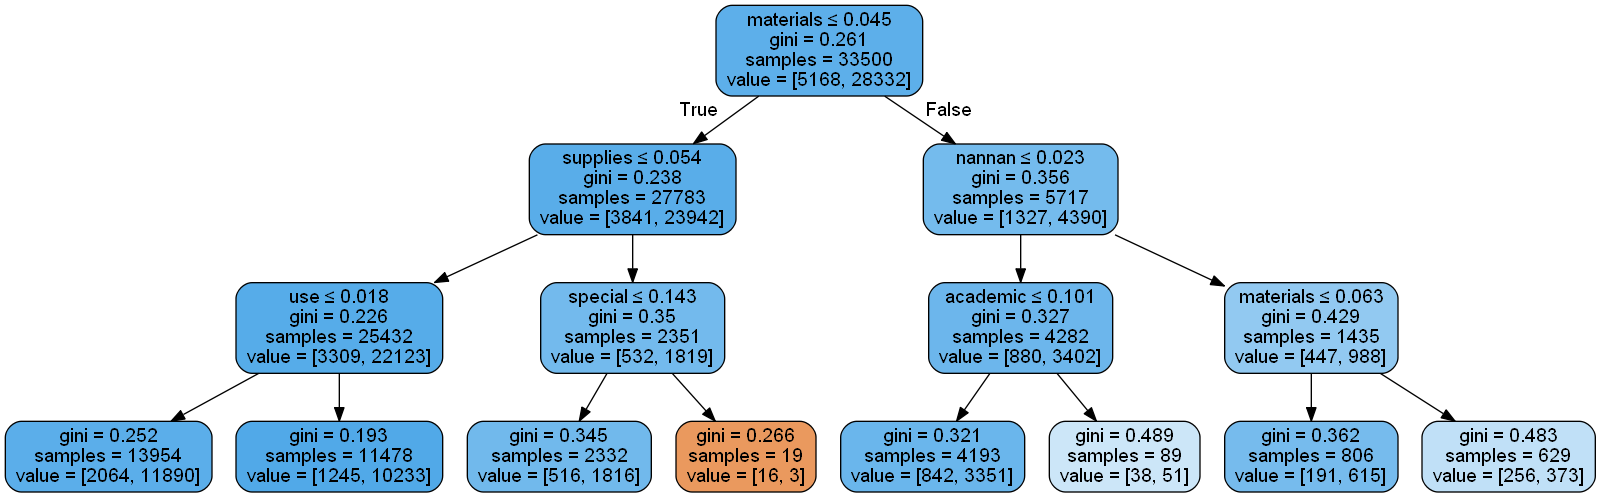

In [225]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dtree = DecisionTreeClassifier(max_depth=3)
clf2 = dtree.fit(X_tr2, y_train)

dot_data = StringIO()

#dt_feat_names = list(X_test.columns)
#dt_target_names = [str(s) for s in [0,1]]
export_graphviz(clf2, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=bow_features_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


## False Positive words from TFIDF encoded Essays

In [226]:
tfidf_test = text_tfidf_test.todense()
tfidf_test.shape

(16500, 10446)

In [227]:
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
bv = vectorizer_tfidf_essay.fit(X_train["clean_essays"])

tfidf_features = bv.get_feature_names()

len(tfidf_features)

10446

In [228]:
y_test_converted = list(y_test[::])

false_positives_index_b = []
fp_count = 0

for i in tqdm(range(len(y_test_pred1))):
    if y_test_converted[i] == 0 and y_test_pred1[i] <= 0.84:
        false_positives_index_b.append(i)
        fp_count = fp_count + 1 
    else :
        continue

100%|████████████████████████████████| 16500/16500 [00:00<00:00, 499974.83it/s]


In [229]:
fp_count

2401

In [230]:
false_positives_index_b[0:5]

[5, 12, 19, 37, 49]

In [231]:
df2 = pd.DataFrame(tfidf_test)
df2_final = df2.iloc[false_positives_index_b,:]
df2_final.shape

(2401, 10446)

In [232]:
best_indices_b = []

for j in range(8885):
    
    s = df2_final[j].sum()
    
    if s >= 10 :
        best_indices_b.append(j)
    else :
        continue       

In [233]:
len(best_indices_b)

363

In [234]:
best_indices_b[0:10]

[124, 184, 185, 186, 212, 226, 272, 296, 302, 303]

In [235]:
tfidf_features[0:10]

['00', '000', '10', '100', '1000', '101', '103', '104', '10th', '11']

In [236]:
fp_words_b = []

for a in best_indices_b :
    fp_words_b.append(str(tfidf_features[a]))
    
fp_words_b[0:10]

['5th',
 'abilities',
 'ability',
 'able',
 'academic',
 'access',
 'achieve',
 'active',
 'activities',
 'activity']

##  Word Cloud for False Positives words

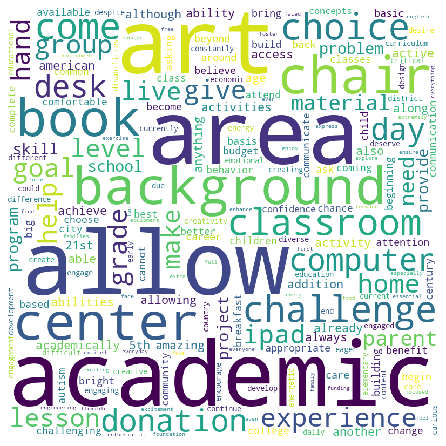

In [237]:
from wordcloud import WordCloud, STOPWORDS


#convert list to string and generate
unique_string=(" ").join(fp_words)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords =stopwords,min_font_size=10).generate(unique_string)

plt.figure(figsize=(6,6))

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
plt.close()

## Box - Plot with the price of these False positive data points

In [238]:
len(false_positives_index_p)

2438

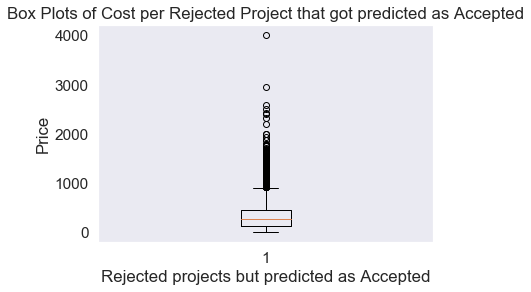

In [239]:
df2 = pd.DataFrame(X_test['price'])
df2_final = df2.iloc[false_positives_index_p,:]

plt.boxplot(df2_final.values)
plt.title('Box Plots of Cost per Rejected Project that got predicted as Accepted')
plt.xlabel('Rejected projects but predicted as Accepted')
plt.ylabel('Price')
plt.grid()
plt.show()

##  PDF with the Teacher_number_of_previously_posted_projects of these False Positive data points

In [240]:
df2 = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
df2_final = df2.iloc[false_positives_index_p,:]
df2_final.shape

(2438, 1)

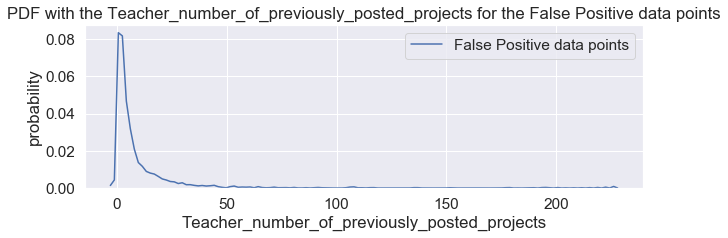

In [241]:
plt.figure(figsize=(10,3))
sns.distplot(df2_final.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.show()

## Set 3 : Categorical, Numerical features + Project_title(AVG W2V) + Preprocessed_essay (AVG W2V)

In [242]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr3 = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, avg_w2v_vectors_train, avg_w2v_vectors_titles_train)).tocsr()
X_te3 = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, avg_w2v_vectors_test, avg_w2v_vectors_titles_test)).tocsr()
#X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, avg_w2v_vectors_cv, avg_w2v_vectors_titles_cv)).tocsr()

print("Final Data matrix")
print(X_tr3.shape, y_train.shape)
#print(X_cv.shape, y_cv.shape)
print(X_te3.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 709) (33500,)
(16500, 709) (16500,)


In [244]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]}

clf3 = GridSearchCV(dt, parameters, cv= 3, scoring='roc_auc', return_train_score = True,n_jobs = -1)

clf3.fit(X_tr3, y_train)

train_auc= clf3.cv_results_['mean_train_score']
train_auc_std= clf3.cv_results_['std_train_score']
cv_auc = clf3.cv_results_['mean_test_score'] 
cv_auc_std= clf3.cv_results_['std_test_score']

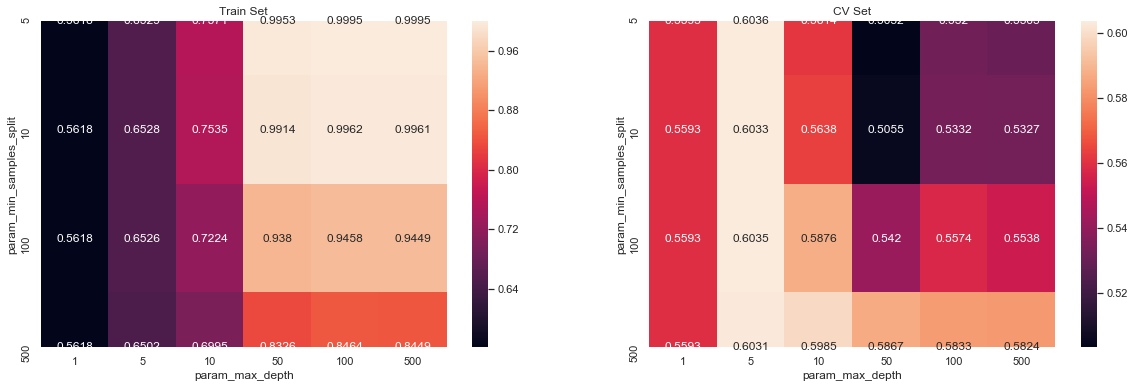

In [245]:
##https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf3.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()


## ROC Curve:


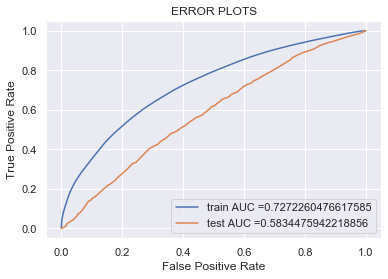

In [246]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function



clf3= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
classifier_bow=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)

clf3.fit(X_tr3, y_train)

# for visulation

classifier_bow.fit(X_tr3, y_train)

y_train_pred1 = clf3.predict_proba(X_tr3) [:,1]
y_test_pred1 = clf3.predict_proba(X_te3) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

plt.show()




## Confusion Matrix:


In [247]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions


In [248]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)))

print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.11 for threshold 0.5
[[ 3591  1577]
 [10187 18145]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2 for threshold 0.54
[[1418 1128]
 [6119 7835]]


the maximum value of tpr*(1-fpr) 0.11 for threshold 0.5


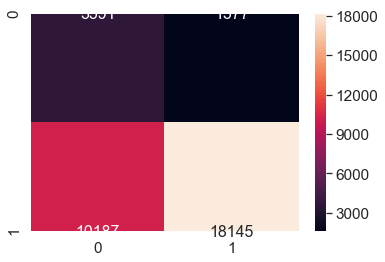

In [249]:
conf_matr_df_train_1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_1, annot=True,annot_kws={"size": 16}, fmt='g')

the maximum value of tpr*(1-fpr) 0.2 for threshold 0.54


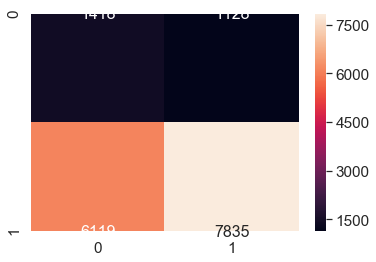

In [250]:
conf_matr_df_test_1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)), range(2),range(2))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_1, annot=True,annot_kws={"size": 16}, fmt='g')


## False Positives Retrieval:


In [251]:
fpi = []
fp_count = 0

for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions1[i] == 1) :
        fpi.append(i)
        fp_count = fp_count + 1 
    else :
        continue

In [252]:
fp_essay3 = []
for i in fpi :
    fp_essay3.append(X_test['clean_essays'].values[i])

In [253]:
fp_count

1128

In [254]:
fpi[0:5]

[103, 111, 157, 159, 177]

In [255]:
df3 = pd.DataFrame(avg_w2v_vectors_test )

In [256]:
df3_final = df3.iloc[fpi,:]
df3_final.shape

(1128, 300)

In [257]:
best_indices_b = []

for j in range(300):
    
    s = df3_final[j].sum()
    
    if s >= 10 :
        best_indices_b.append(j)
    else :
        continue

In [258]:
len(best_indices_b)

128

In [259]:
best_indices_b[0:10]

[0, 1, 7, 8, 10, 12, 16, 18, 20, 21]

## Word cloud for false positive words:

In [260]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


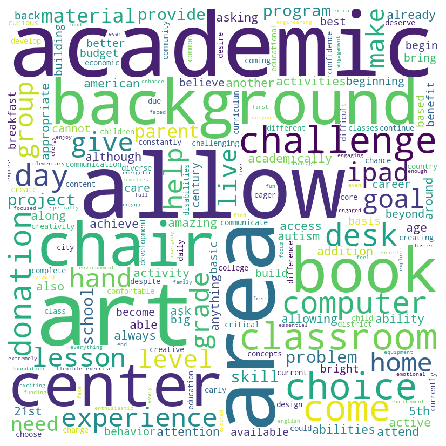

In [261]:
from wordcloud import WordCloud, STOPWORDS


#convert list to string and generate
unique_string=(" ").join(fp_words)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords =stopwords,min_font_size=10).generate(unique_string)

plt.figure(figsize=(6,6))

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
plt.close()

## Box - Plot with the price of these False positive data points:

In [262]:
len(fpi)

1128

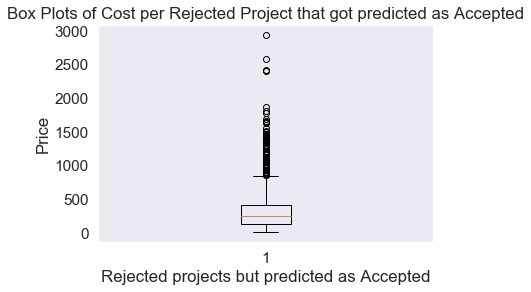

In [263]:
df3 = pd.DataFrame(X_test['price'])
df3_final = df3.iloc[fpi,:]

plt.boxplot(df3_final.values)
plt.title('Box Plots of Cost per Rejected Project that got predicted as Accepted')
plt.xlabel('Rejected projects but predicted as Accepted')
plt.ylabel('Price')
plt.grid()
plt.show()

## PDF with the Teacher_number_of_previously_posted_projects of these False Positive data points:

In [264]:
df3 = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
df3_final = df3.iloc[false_positives_index_p,:]
df3_final.shape

(2438, 1)

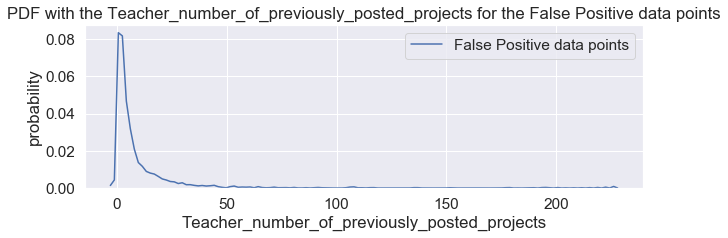

In [265]:
plt.figure(figsize=(10,3))
sns.distplot(df2_final.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.show()

 ## Set 4 : Categorical, Numerical features + Project_title(TFIDF W2V) + Preprocessed_essay (TFIDF W2V)

In [266]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr4 = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, tfidf_w2v_vectors_train, tfidf_w2v_vectors_titles_train)).tocsr()
X_te4 = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, tfidf_w2v_vectors_test, tfidf_w2v_vectors_titles_test)).tocsr()
#X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, tfidf_w2v_vectors_cv, tfidf_w2v_vectors_titles_cv)).tocsr()

print("Final Data matrix")
print(X_tr4.shape, y_train.shape)
#print(X_cv.shape, y_cv.shape)
print(X_te4.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 709) (33500,)
(16500, 709) (16500,)


In [267]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]}

clf4 = GridSearchCV(dt, parameters, cv= 3, scoring='roc_auc', return_train_score = True,n_jobs = -1)

clf4.fit(X_tr4, y_train)

train_auc= clf4.cv_results_['mean_train_score']
train_auc_std= clf4.cv_results_['std_train_score']
cv_auc = clf4.cv_results_['mean_test_score'] 
cv_auc_std= clf4.cv_results_['std_test_score']

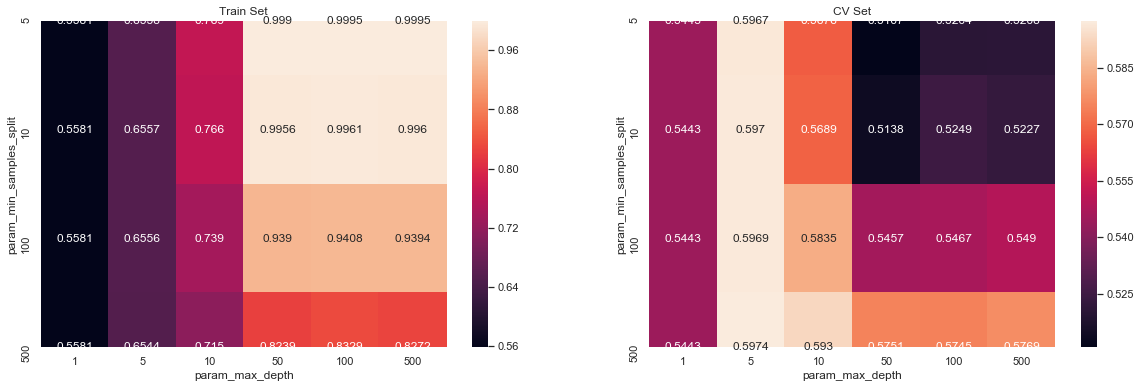

In [268]:
##https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf4.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()


## ROC Curve:


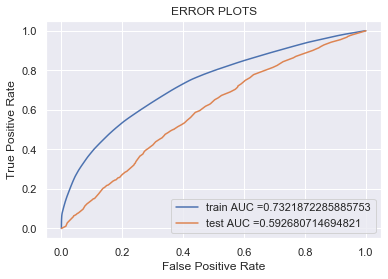

In [269]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function



clf4= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
classifier_bow=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)

clf4.fit(X_tr4, y_train)

# for visulation

classifier_bow.fit(X_tr4, y_train)

y_train_pred1 = clf4.predict_proba(X_tr4) [:,1]
y_test_pred1 = clf4.predict_proba(X_te4) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

plt.show()




## Confusion Matrix:


In [270]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions


In [271]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)))

print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.11 for threshold 0.49
[[ 3545  1623]
 [ 9818 18514]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.19 for threshold 0.5
[[1426 1120]
 [5763 8191]]


the maximum value of tpr*(1-fpr) 0.11 for threshold 0.49


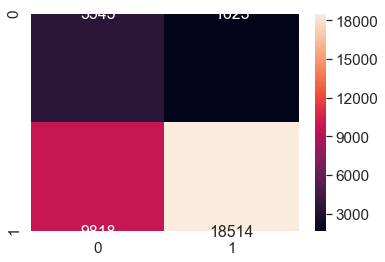

In [272]:
conf_matr_df_train_1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_1, annot=True,annot_kws={"size": 16}, fmt='g')

the maximum value of tpr*(1-fpr) 0.19 for threshold 0.5


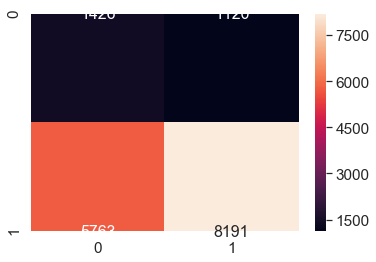

In [273]:
conf_matr_df_test_1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)), range(2),range(2))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_1, annot=True,annot_kws={"size": 16}, fmt='g')


## False Positives Retrieval:


In [274]:
y_test_conaverted = list(y_test[::])

false_positives_index_p = []
fp_count = 0

for i in tqdm(range(len(y_test_pred1))):
    if y_test_conaverted[i] == 0 and y_test_pred1[i] <= 0.839:
        false_positives_index_p.append(i)
        fp_count = fp_count + 1 
    else :
        continue

100%|████████████████████████████████| 16500/16500 [00:00<00:00, 323512.03it/s]


In [275]:
fp_count

2349

In [276]:
false_positives_index_p[0:7]

[5, 12, 19, 37, 49, 51, 62]

In [277]:
df4 = pd.DataFrame(tfidf_w2v_vectors_train)
df4_final = df4.iloc[false_positives_index_p,:]

df4_final.shape

df4_final[0].sum()

47.86317441816917

In [281]:
best_indices = []

for j in range(300):
    
    s = df4_final[j].sum()
    
    if s >= 100 :
        best_indices.append(j)
    else :
        continue

len(best_indices)

69

In [282]:
best_indices[0:10]

[7, 12, 18, 26, 33, 41, 46, 56, 59, 62]

##  Word cloud for false positive words

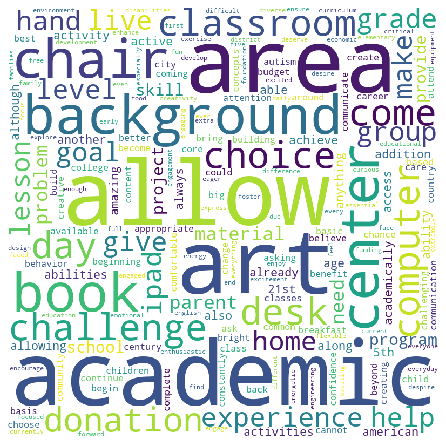

In [283]:
from wordcloud import WordCloud, STOPWORDS


#convert list to string and generate
unique_string=(" ").join(fp_words)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords =stopwords,min_font_size=10).generate(unique_string)

plt.figure(figsize=(6,6))

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
plt.close()

## Box - Plot with the price of these False positive data points


In [284]:
len(false_positives_index_p)

2349

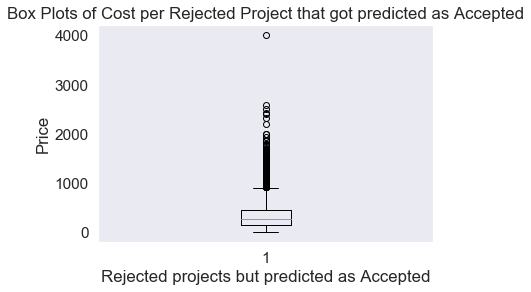

In [285]:
df4 = pd.DataFrame(X_test['price'])
df4_final = df4.iloc[false_positives_index_p,:]

plt.boxplot(df4_final.values)
plt.title('Box Plots of Cost per Rejected Project that got predicted as Accepted')
plt.xlabel('Rejected projects but predicted as Accepted')
plt.ylabel('Price')
plt.grid()
plt.show()

##### Summary - Majority of projects rejected but predicted as accepted cost nearly less than 500 dollars. A few of them are Extremely costing over 3000 dollars.

##  PDF with the Teacher_number_of_previously_posted_projects of these False Positive data points

In [286]:
df4 = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
df4_final = df4.iloc[false_positives_index_p,:]
df4_final.shape

(2349, 1)

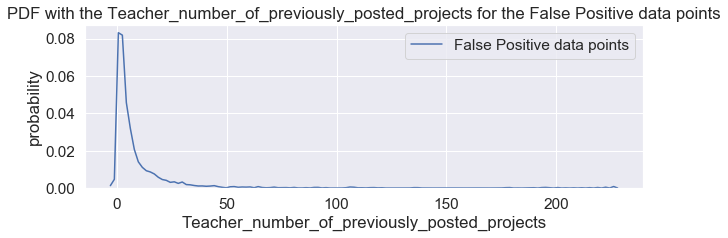

In [287]:
plt.figure(figsize=(10,3))
sns.distplot(df4_final.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.show()

##### Summary - Most cases have teachers with projects previously posted as 0 (nearly 10% of the total data)

# [Task 2] Select best 5k features from Set 2

In [96]:
#https://stackoverflow.com/questions/47111434/randomforestregressor-and-feature-importances-error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def selectKImportance(model, X, k=5):
    return X[:,model.best_estimator_.feature_importances_.argsort()[::-1][:k]]

In [124]:
X_tr5 = selectKImportance(clf2, X_tr2, 5000)
X_te5 = selectKImportance(clf2, X_te2, 5000)
print(X_tr5.shape)
print(X_te5.shape)

(33500, 5000)
(16500, 5000)


## Decision tree on Important features

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]}

clf5 = GridSearchCV(dt, parameters, cv= 3, scoring='roc_auc', return_train_score = True,n_jobs = -1)

clf5.fit(X_tr5, y_train)

train_auc= clf5.cv_results_['mean_train_score']
train_auc_std= clf5.cv_results_['std_train_score']
cv_auc = clf5.cv_results_['mean_test_score'] 
cv_auc_std= clf5.cv_results_['std_test_score']

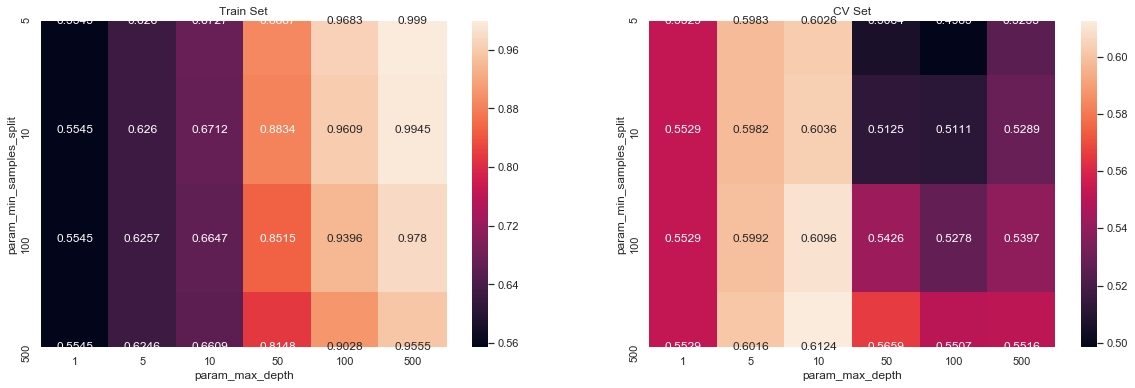

In [126]:
##https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf5.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()


In [127]:
#Best Estimator and Best tune parameters
print(clf5.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf5.score(X_tr5,y_train))
print(clf5.score(X_te5,y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.6633545218645875
0.6176711698104457


In [128]:
# Best tune parameters
best_tune_parameters=[{'max_depth':[10], 'min_samples_split':[500] } ]

clf5.get_params().keys()


dict_keys(['cv', 'error_score', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__presort', 'estimator__random_state', 'estimator__splitter', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

### ROC

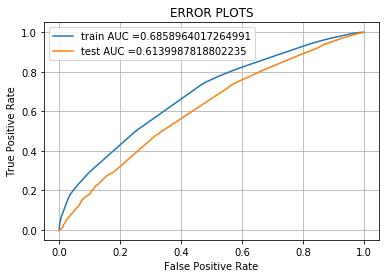

In [111]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function



clf5= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
clf_5=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)

clf5.fit(newX_tr, y_train)

# for visulation

clf_5.fit(newX_tr, y_train)

y_train_pred1 = clf5.predict_proba(newX_tr) [:,1]
y_test_pred1 = clf5.predict_proba(newX_te) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

plt.show()




### Confusion Matrix

In [115]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions


In [129]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)))

print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred1, tr_thresholds1, test_tpr1, test_fpr1)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.13 for threshold 0.52
[[ 2765  2403]
 [ 7572 20760]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.17 for threshold 0.54
[[1699  847]
 [7048 6906]]


In [119]:
conf_matr_df_train_5 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.13 for threshold 0.52


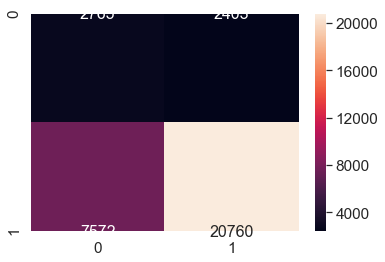

In [120]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_5, annot=True,annot_kws={"size": 16}, fmt='g')

In [121]:
conf_matr_df_test_5 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_tpr1, train_fpr1)), range(2),range(2))


the maximum value of tpr*(1-fpr) 0.13 for threshold 0.52


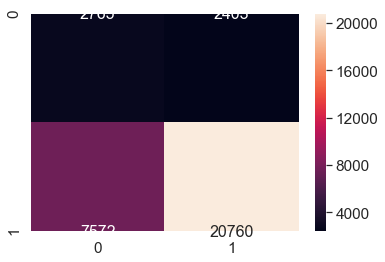

In [122]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_5, annot=True,annot_kws={"size": 16}, fmt='g')

# 3. Conclusion

In [174]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameters(max depth,min samples split)", "Train AUC", "Test AUC"]

x.add_row(["BOW", "Decision Trees","(10, 100)", 0.669, 0.620])
x.add_row(["TFIDF", "Decision Trees", "(10, 500)", 0.688, 0.620])
x.add_row(["AVG W2V", "Decision Trees", "(5, 500)", 0.727, 0.583])
x.add_row(["TFIDF W2V", "Decision Trees", "(10, 100)", 0.732, 0.592])
x.add_row(["TFIDF-5k Features","Decision Trees", "(10, 500 ) ",  0.685, 0.613])
print(x.get_string(titles = "Decision trees- Observations"))

+-------------------+----------------+----------------------------------------------+-----------+----------+
|     Vectorizer    |     Model      | Hyperparameters(max depth,min samples split) | Train AUC | Test AUC |
+-------------------+----------------+----------------------------------------------+-----------+----------+
|        BOW        | Decision Trees |                  (10, 100)                   |   0.669   |   0.62   |
|       TFIDF       | Decision Trees |                  (10, 500)                   |   0.688   |   0.62   |
|      AVG W2V      | Decision Trees |                   (5, 500)                   |   0.727   |  0.583   |
|     TFIDF W2V     | Decision Trees |                  (10, 100)                   |   0.732   |  0.592   |
| TFIDF-5k Features | Decision Trees |                 (10, 500 )                   |   0.685   |  0.613   |
+-------------------+----------------+----------------------------------------------+-----------+----------+
